In [4]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tqdm
from flair.models import TextClassifier
from flair.data import Sentence
from afinn import Afinn
from senticnet.senticnet import SenticNet
from transformers import pipeline
from pattern.en import sentiment
from abbreviations import abbreviations_romanticism, abbreviations_nihilism, abbreviations_stoicism

In [2]:
#!pip install pandas numpy nltk textblob matplotlib seaborn vaderSentiment tqdm flair afinn senticnet transformers pattern abbreviations

In [2]:
# Download NLTK stopwords for text filtering. Loading sentiment
# analysis tools that will be found in next cell.
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


classifier = TextClassifier.load('en-sentiment')
sentiment_pipeline = pipeline("sentiment-analysis")
afinn = Afinn()
sn = SenticNet()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aaron\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
def read_text_files(directory):
    """ Load all text files from the specified
    directory, reading their content and storing the filenames."""
    texts = []
    filenames = []
    for filename in os.listdir(directory):
        if filename.endswith('.txt'):
            with open(os.path.join(directory, filename), 'r', encoding='utf-8') as file:
                text = file.read()
                texts.append(text)
                filenames.append(filename)
    return texts, filenames

def preprocess_text(text):
    """Convert text to lowercase, remove punctuation, 
    and filter out stopwords for text preprocessing."""
    text = text.lower()
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  
    text = ' '.join([word for word in text.split() if word not in stop_words])  
    return text

def get_sentiment_score_TextBlob(text):
    """Calculate sentiment polarity score using TextBlob,
    ranging from -1 (negative) to 1 (positive)."""
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

def get_sentiment_score_vader(text):
    """Compute sentiment compound score using VADER, which provides a normalized score from -1 to 1"""
    analyzer = SentimentIntensityAnalyzer()
    sentiment_dict = analyzer.polarity_scores(text)
    return sentiment_dict['compound']

def get_sentiment_score_flair(text):
    """Use the Flair sentiment classifier to get a sentiment score, 
    positive or negative, based on model prediction."""
    sentence = Sentence(text)
    classifier.predict(sentence)
    if sentence.labels:  
        label = sentence.labels[0]
        # Return score as positive value for 'POSITIVE' or negative for 'NEGATIVE'
        
        score = label.score if label.value == 'POSITIVE' else -label.score
    else:
        score = 0  # Return neutral sentiment if no labels are found
    return score

def get_sentiment_score_afinn(text):
    """Compute sentiment score using AFINN, a lexicon-based approach
    where words have pre-assigned sentiment values."""
    return afinn.score(text)

def get_sentiment_score_senticnet(text):
    """Calculate sentiment score using SenticNet by summing the 
    polarity of known words and normalizing by word count."""
    words = text.split()
    total_score = 0
    for word in words:
        try:
            total_score += float(sn.polarity_value(word))
        except KeyError:
            continue  # Skip words not found in SenticNet
    # Normalize score by number of words in the text
    return total_score / len(words) if words else 0

def get_sentiment_score_transformer(text, max_length=512):
    """Get sentiment score using a transformer-based model, 
    truncating text if it exceeds the specified max length."""
    # Truncate text if it exceeds max_length
    truncated_text = text[:max_length]
    result = sentiment_pipeline(truncated_text)[0]
    score = result['score'] if result['label'] == 'POSITIVE' else -result['score']
    return score

def get_sentiment_score_pattern(text):
    """Calculate sentiment polarity using the Pattern library, 
    which returns a value from -1 to 1."""
    polarity, subjectivity = sentiment(text)
    return polarity



# Nihilism Code

In [11]:
# Set the directory path to the 'Nihilism' folder within the current working directory.
directory = os.path.join(os.getcwd(), 'Nihilism')

# Read text files from the specified directory and get their filenames.
texts, filenames = read_text_files(directory)

# Initialize an empty list to store the mean sentiment scores for each text.
mean_sentiment_scores = []

# Define a belief map categorizing philosophers as 'Nihilistic' or 'Not Nihilistic' based on their views.
nihilism_belief_map = {
    'Nietzsche': 'Nihilistic',
    'Cioran': 'Nihilistic',
    'Schopenhauer': 'Nihilistic',
    'Sartre': 'Nihilistic',
    'Camus': 'Not Nihilistic',
    'Marcel': 'Not Nihilistic',
    'Kierkegaard': 'Not Nihilistic',
    'Buber': 'Not Nihilistic'
}

# Process each text file to calculate sentiment scores using various methods.
for text, filename in tqdm(zip(texts, filenames), total=len(filenames), desc="Processing Text Files"):
    # Split the text into paragraphs and store them in a DataFrame.
    paragraphs = text.split('\n\n')
    df = pd.DataFrame(paragraphs, columns=['text'])
    
    # Preprocess the text by converting to lowercase, removing punctuation, and filtering out stopwords.
    df['cleaned_text'] = df['text'].apply(preprocess_text)
    
    # Remove any rows with empty or whitespace-only cleaned text.
    df = df[df['cleaned_text'].str.strip() != '']  
    
    # If all paragraphs are empty after preprocessing, print a warning and skip to the next file.
    if df.empty:
        print(f"Warning: All paragraphs in {filename} became empty after preprocessing.")
        continue
    
    # Calculate sentiment scores using different sentiment analysis methods.
    df['sentiment_score_textblob'] = df['cleaned_text'].apply(get_sentiment_score_TextBlob)
    df['sentiment_score_vader'] = df['cleaned_text'].apply(get_sentiment_score_vader)
    df['sentiment_score_flair'] = df['cleaned_text'].apply(get_sentiment_score_flair)
    df['sentiment_score_afinn'] = df['cleaned_text'].apply(get_sentiment_score_afinn)
    df['sentiment_score_senticnet'] = df['cleaned_text'].apply(get_sentiment_score_senticnet)
    df['sentiment_score_transformer'] = df['cleaned_text'].apply(get_sentiment_score_transformer)
    df['sentiment_score_pattern'] = df['cleaned_text'].apply(get_sentiment_score_pattern)
    
    # Calculate the mean sentiment score for each method.
    mean_sentiment_score_textblob = df['sentiment_score_textblob'].mean()
    mean_sentiment_score_vader = df['sentiment_score_vader'].mean()
    mean_sentiment_score_flair = df['sentiment_score_flair'].mean()
    mean_sentiment_score_afinn = df['sentiment_score_afinn'].mean()
    mean_sentiment_score_senticnet = df['sentiment_score_senticnet'].mean()
    mean_sentiment_score_transformer = df['sentiment_score_transformer'].mean()
    mean_sentiment_score_pattern = df['sentiment_score_pattern'].mean()
    
    # Extract the philosopher's name from the filename.
    philosopher_name = filename.split('_')[0]
    
    # Append the mean sentiment scores and belief classification to the list.
    mean_sentiment_scores.append({
        'filename': filename, 
        'philosopher': philosopher_name,
        'mean_sentiment_score_textblob': mean_sentiment_score_textblob,
        'mean_sentiment_score_vader': mean_sentiment_score_vader,
        'mean_sentiment_score_flair': mean_sentiment_score_flair,
        'mean_sentiment_score_afinn': mean_sentiment_score_afinn,
        'mean_sentiment_score_senticnet': mean_sentiment_score_senticnet,
        'mean_sentiment_score_transformer': mean_sentiment_score_transformer,
        'mean_sentiment_score_pattern': mean_sentiment_score_pattern,
        'belief': nihilism_belief_map[philosopher_name]
    })

mean_sentiment_df = pd.DataFrame(mean_sentiment_scores)

Processing Text Files: 100%|██████████████████████████████████████████████████████████| 23/23 [38:24<00:00, 100.18s/it]

Save data frame to CSV on first run so you don't have to run each time.

In [17]:
#mean_sentiment_df.to_csv('nihilism_sentiment_analysis.csv', index=False)

#### Classification Rate

In [6]:
metrics = [
    'mean_sentiment_score_textblob',
    'mean_sentiment_score_vader',
    'mean_sentiment_score_flair',
    'mean_sentiment_score_afinn',
    'mean_sentiment_score_senticnet',
    'mean_sentiment_score_transformer',
    'mean_sentiment_score_pattern'
]

nihilism_sentiment_df = pd.read_csv('nihilism_sentiment_analysis.csv')

# Iterate through each metric and calculate the classification rate
for metric in metrics:
    # Step 1: Sort the texts by the current sentiment metric score in descending order
    sorted_df = nihilism_sentiment_df.sort_values(by=metric, ascending=False)

    # Step 2: Identify the top 12 texts and count how many are correctly classified as "Non-Nihilistic"
    top_12_texts = sorted_df.head(12)
    correct_classifications = top_12_texts[top_12_texts['belief'] == 'Not Nihilistic'].shape[0]

    # Step 3: Calculate the classification rate for this metric
    classification_rate = correct_classifications / 12  # Since we are using the top 12 texts

    # Output the classification rate for the current metric
    print(f"{metric.replace('mean_sentiment_score_', '').capitalize()} Classification Rate: {classification_rate:.2f}")

Textblob Classification Rate: 0.58
Vader Classification Rate: 0.50
Flair Classification Rate: 0.67
Afinn Classification Rate: 0.42
Senticnet Classification Rate: 0.58
Transformer Classification Rate: 0.58
Pattern Classification Rate: 0.58


#### Plotting

In [1]:
# Directory for nihilism plots
output_dir = 'plots_nihilism'  

# Create the directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Create scatter plots for each metric
for metric in metrics:
    plt.figure(figsize=(11, 5))  
    
    added_labels = {'Nihilistic': False, 'Not Nihilistic': False}
    
    for index, row in nihilism_sentiment_df.iterrows():
        # Use abbreviations for filenames, if available, otherwise use the full filename
        x = abbreviations_nihilism.get(row['filename'], row['filename'])
        y = row[metric]
        belief = row['belief']
        color = 'red' if belief == 'Nihilistic' else 'blue'
        marker_shape = 'o' if belief == 'Nihilistic' else '^'
        
        # Add label to the legend only once per category
        if not added_labels[belief]:
            plt.scatter(x, y, color=color, s=200, alpha=0.8, label=belief, marker=marker_shape)
            added_labels[belief] = True
        else:
            plt.scatter(x, y, color=color, s=200, alpha=0.8, marker=marker_shape)
    
    # Add a dotted line at y=0 to indicate neutral sentiment
    plt.axhline(0, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
    
    # Rotate x-axis labels 45 degrees for better readability
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.title(f'Mean Sentiment Score by Text ({metric.replace("mean_sentiment_score_", "").capitalize()})', fontsize=14)
    plt.xlabel('Text (Author - Book Name)', fontsize=12)
    plt.ylabel('Mean Sentiment Score', fontsize=12)
    
    # Add a black border around the entire plot
    plt.gca().spines['top'].set_color('black')
    plt.gca().spines['bottom'].set_color('black')
    plt.gca().spines['left'].set_color('black')
    plt.gca().spines['right'].set_color('black')
    plt.gca().spines['top'].set_linewidth(1.5)
    plt.gca().spines['bottom'].set_linewidth(1.5)
    plt.gca().spines['left'].set_linewidth(1.5)
    plt.gca().spines['right'].set_linewidth(1.5)

    plt.tight_layout() 
    plt.grid(True, linestyle='--', alpha=0.6, color='gray')  
    plt.tick_params(axis='both', which='both', length=5, width=1, color='black') 
    
    # Add a legend with smaller marker size
    legend = plt.legend(title='Belief', fontsize=10, title_fontsize=12, loc='upper right', markerscale=0.8)
    
    plt.savefig(os.path.join(output_dir, f'{metric}_nihilism_plot.png'), bbox_inches='tight')
    
    plt.show()

NameError: name 'os' is not defined

## Romanticism Code

In [16]:
romanticism_belief_map = {
    'Rousseau': 'Romantic',
    'Goethe': 'Romantic',
    'Wordsworth': 'Romantic',
    'Coleridge': 'Romantic',
    'Kant': 'Non-Romantic',
    'Burke': 'Non-Romantic',
    'Hegel': 'Non-Romantic',
    'Hume': 'Non-Romantic'
}

directory = os.path.join(os.getcwd(), 'Romanticism')

texts, filenames = read_text_files(directory)

mean_sentiment_scores = []

for text, filename in tqdm(zip(texts, filenames), total=len(filenames), desc="Processing Text Files"):

    print(f"Processing file: {filename}")
    
    paragraphs = text.split('\n\n')
    df = pd.DataFrame(paragraphs, columns=['text'])
    df['cleaned_text'] = df['text'].apply(preprocess_text)
    
    
    df = df[df['cleaned_text'].str.strip() != '']  
    
    if df.empty:
        print(f"Warning: All paragraphs in {filename} became empty after preprocessing.")
        continue
    
    df['sentiment_score_textblob'] = df['cleaned_text'].apply(get_sentiment_score_TextBlob)
    df['sentiment_score_vader'] = df['cleaned_text'].apply(get_sentiment_score_vader)
    df['sentiment_score_flair'] = df['cleaned_text'].apply(get_sentiment_score_flair)
    df['sentiment_score_afinn'] = df['cleaned_text'].apply(get_sentiment_score_afinn)
    df['sentiment_score_senticnet'] = df['cleaned_text'].apply(get_sentiment_score_senticnet)
    df['sentiment_score_transformer'] = df['cleaned_text'].apply(get_sentiment_score_transformer)
    df['sentiment_score_pattern'] = df['cleaned_text'].apply(get_sentiment_score_pattern)
    
    mean_sentiment_score_textblob = df['sentiment_score_textblob'].mean()
    mean_sentiment_score_vader = df['sentiment_score_vader'].mean()
    mean_sentiment_score_flair = df['sentiment_score_flair'].mean()
    mean_sentiment_score_afinn = df['sentiment_score_afinn'].mean()
    mean_sentiment_score_senticnet = df['sentiment_score_senticnet'].mean()
    mean_sentiment_score_transformer = df['sentiment_score_transformer'].mean()
    mean_sentiment_score_pattern = df['sentiment_score_pattern'].mean()
    
    philosopher_name = filename.split('_')[0]
    
    
    mean_sentiment_scores.append({
        'filename': filename, 
        'philosopher': philosopher_name,
        'mean_sentiment_score_textblob': mean_sentiment_score_textblob,
        'mean_sentiment_score_vader': mean_sentiment_score_vader,
        'mean_sentiment_score_flair': mean_sentiment_score_flair,
        'mean_sentiment_score_afinn': mean_sentiment_score_afinn,
        'mean_sentiment_score_senticnet': mean_sentiment_score_senticnet,
        'mean_sentiment_score_transformer': mean_sentiment_score_transformer,
        'mean_sentiment_score_pattern': mean_sentiment_score_pattern,
        'belief': romanticism_belief_map[philosopher_name]
    })

mean_sentiment_df = pd.DataFrame(mean_sentiment_scores)

Processing Text Files:   0%|                                                                    | 0/22 [00:00<?, ?it/s]

Processing file: Burke_Reflections.txt


Processing Text Files:   5%|██▋                                                         | 1/22 [00:56<19:49, 56.66s/it]

Processing file: Burke_VindicationNaturalSociety.txt
Processing file: Coleridge_kubla.txt


Processing Text Files:  14%|████████▏                                                   | 3/22 [00:59<05:00, 15.81s/it]

Processing file: Coleridge_The-Rime-of-the-Ancient-Mariner.txt


Processing Text Files:  18%|██████████▉                                                 | 4/22 [01:19<05:10, 17.27s/it]

Processing file: Goethe_Apprecitce.txt


Processing Text Files:  23%|█████████████▋                                              | 5/22 [03:37<16:12, 57.19s/it]

Processing file: Goethe_faust.txt


Processing Text Files:  27%|████████████████                                           | 6/22 [08:41<36:21, 136.34s/it]

Processing file: Goethe_Sorrows.txt


Processing Text Files:  32%|███████████████████                                         | 7/22 [08:47<23:50, 95.35s/it]

Processing file: Hegel_right.txt


Processing Text Files:  36%|█████████████████████▊                                      | 8/22 [09:57<20:26, 87.64s/it]

Processing file: Hegel_The Phenomenology of Spirit .txt


Processing Text Files:  41%|████████████████████████▏                                  | 9/22 [14:46<32:20, 149.25s/it]

Processing file: Hegel_The_Science_of_Logic.txt


Processing Text Files:  45%|██████████████████████████▎                               | 10/22 [22:11<47:52, 239.39s/it]

Processing file: Hume_enquiry.txt


Processing Text Files:  50%|█████████████████████████████                             | 11/22 [22:43<32:23, 176.65s/it]

Processing file: Hume_Natural_Religion.txt


Processing Text Files:  55%|███████████████████████████████▋                          | 12/22 [23:29<22:50, 137.04s/it]

Processing file: Hume_Treatise_Human_Nature.txt


Processing Text Files:  59%|██████████████████████████████████▎                       | 13/22 [25:47<20:37, 137.47s/it]

Processing file: Kant_Groundwork.txt


Processing Text Files:  64%|████████████████████████████████████▉                     | 14/22 [26:42<14:59, 112.48s/it]

Processing file: Kant_Immanuel_Judgement.txt


Processing Text Files:  68%|███████████████████████████████████████▌                  | 15/22 [33:05<22:37, 193.93s/it]

Processing file: Kant_Pure_reason.txt


Processing Text Files:  73%|██████████████████████████████████████████▏               | 16/22 [43:15<31:53, 318.92s/it]

Processing file: Rousseau_Education.txt


Processing Text Files:  77%|████████████████████████████████████████████▊             | 17/22 [45:17<21:39, 259.90s/it]

Processing file: Rousseau_Social_Contract.txt


Processing Text Files:  82%|███████████████████████████████████████████████▍          | 18/22 [46:34<13:39, 204.78s/it]

Processing file: Rousseau_The_Confessions-Jean-Jacques_Rousseau.txt


Processing Text Files:  86%|██████████████████████████████████████████████████        | 19/22 [49:28<09:46, 195.57s/it]

Processing file: Wordsworth_Ballads.txt


Processing Text Files:  91%|████████████████████████████████████████████████████▋     | 20/22 [52:19<06:16, 188.16s/it]

Processing file: Wordsworth_Prelude.txt


Processing Text Files:  95%|███████████████████████████████████████████████████████▎  | 21/22 [55:48<03:14, 194.56s/it]

Processing file: Wordsworth_tintern.txt


Processing Text Files: 100%|██████████████████████████████████████████████████████████| 22/22 [55:51<00:00, 152.36s/it]


In [2]:
#mean_sentiment_df.to_csv('romanticism_sentiment_analysis.csv', index=False)

#### Classification

In [8]:
romanticism_sentiment_df = pd.read_csv('romanticism_sentiment_analysis.csv')

for metric in metrics:
    sorted_df = romanticism_sentiment_df.sort_values(by=metric, ascending=False)

    top_11_texts = sorted_df.head(11)
    correct_classifications = top_11_texts[top_11_texts['belief'] == 'Romantic'].shape[0]

    classification_rate = correct_classifications / 11 

    print(f"{metric.replace('mean_sentiment_score_', '').capitalize()} Classification Rate: {classification_rate:.2f}")

Textblob Classification Rate: 0.55
Vader Classification Rate: 0.36
Flair Classification Rate: 0.73
Afinn Classification Rate: 0.36
Senticnet Classification Rate: 0.27
Transformer Classification Rate: 0.64
Pattern Classification Rate: 0.55


#### Plotting

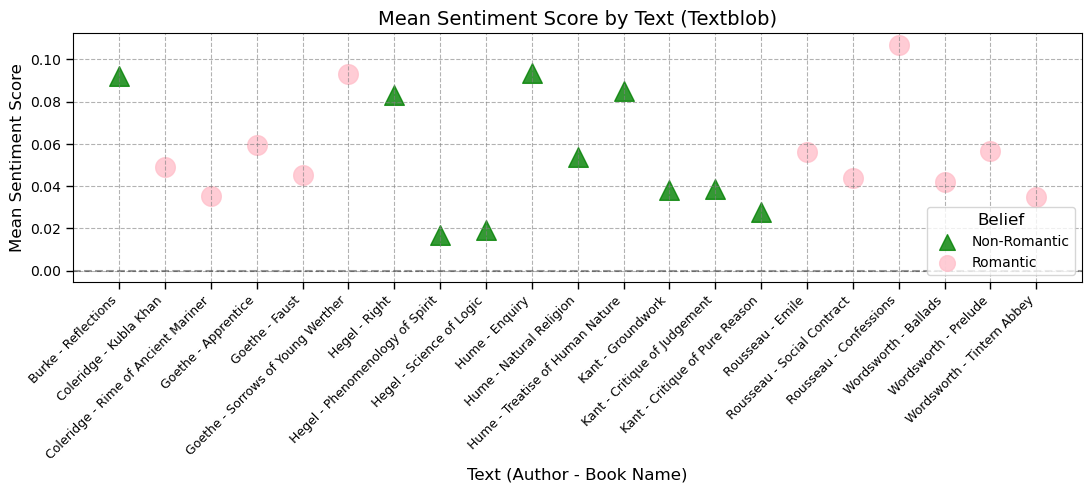

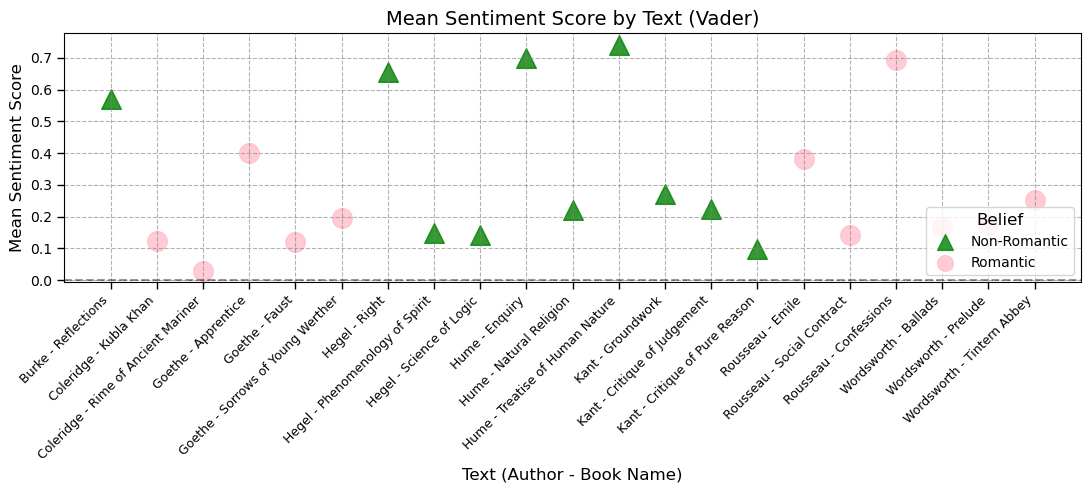

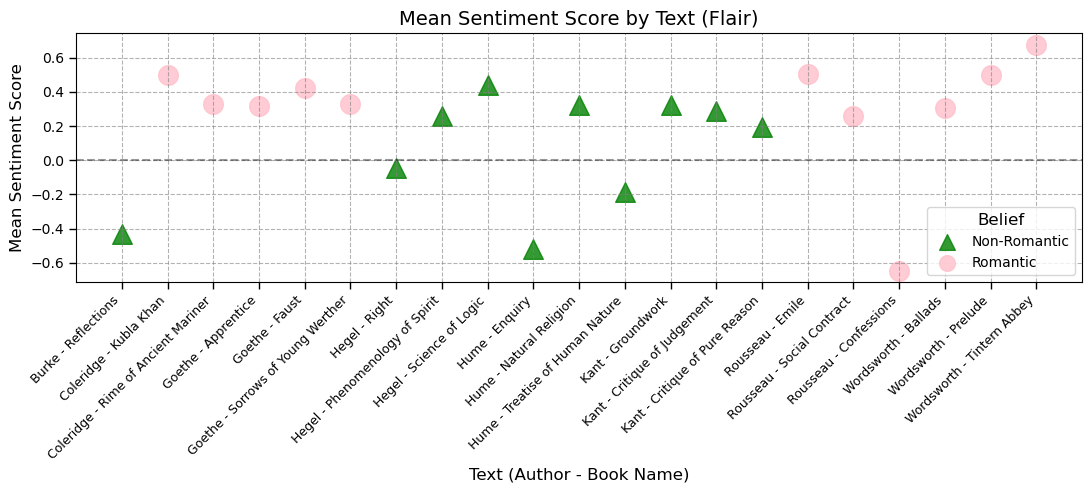

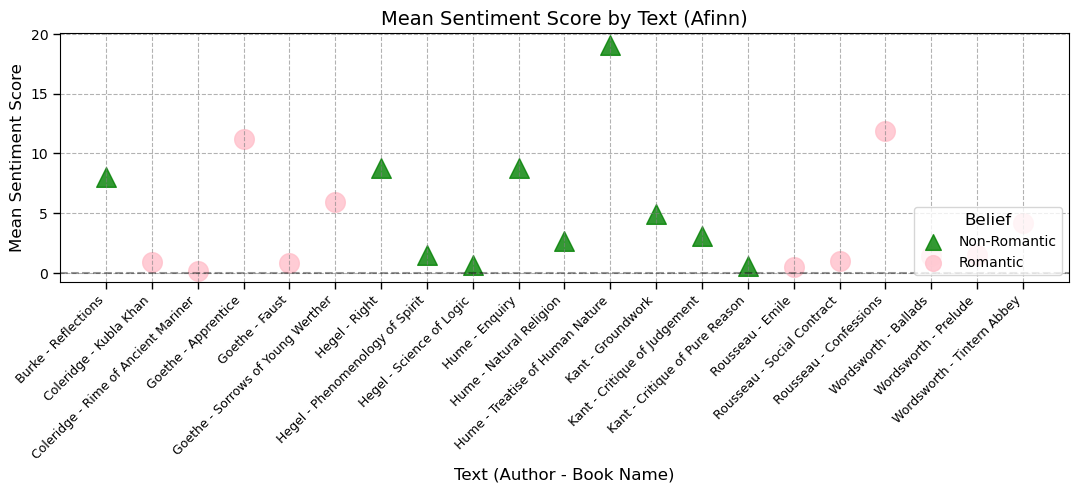

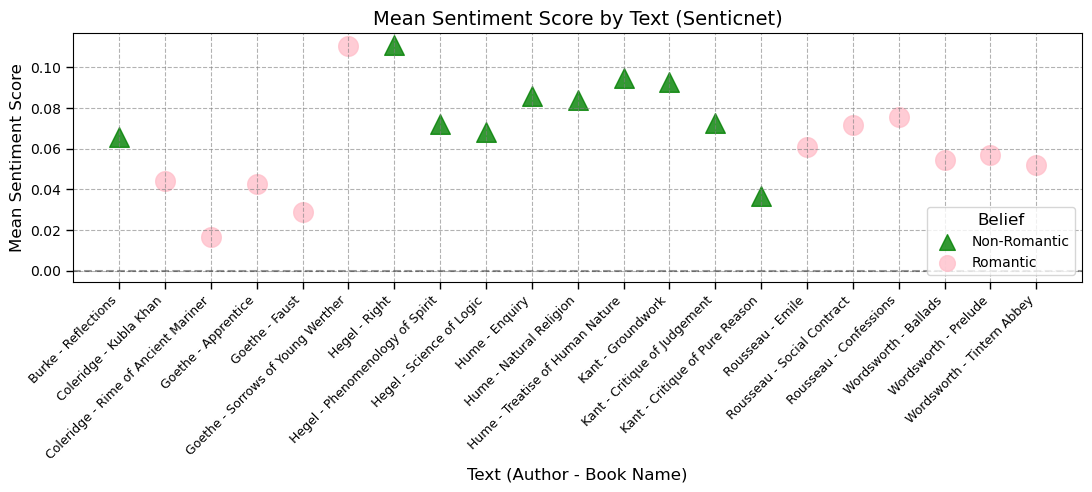

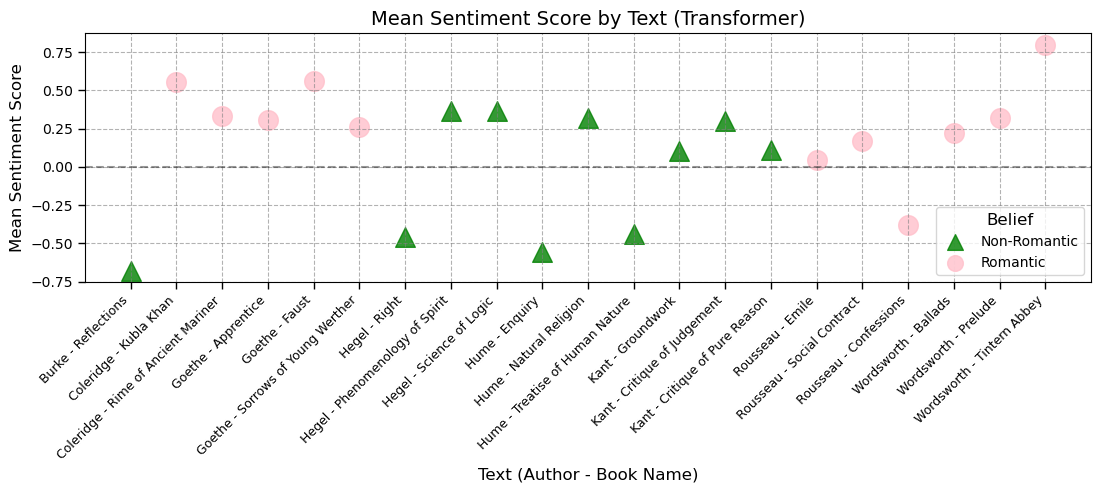

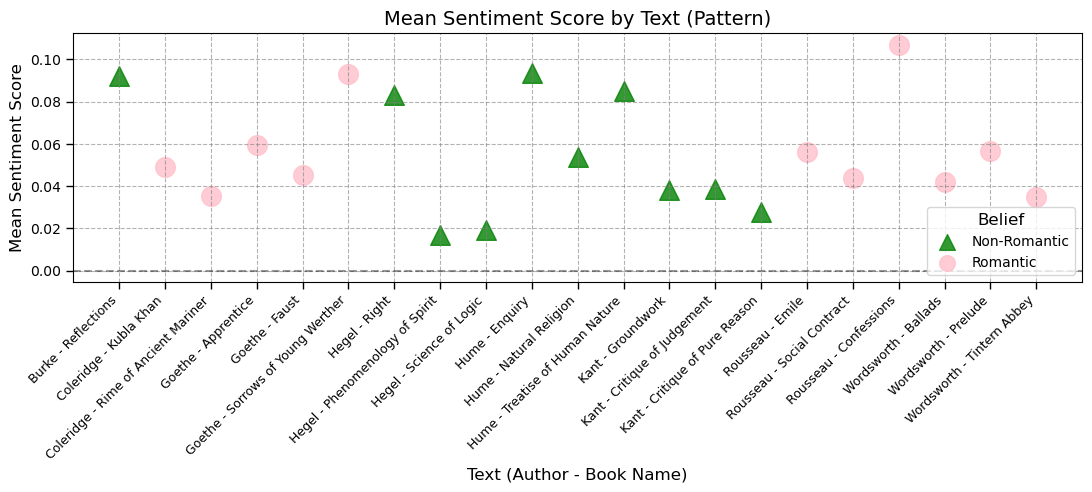

In [9]:
output_dir = 'plots_romanticism'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for metric in metrics:
    plt.figure(figsize=(11, 5))
    
    added_labels = {'Romantic': False, 'Non-Romantic': False}
    
    for index, row in romanticism_sentiment_df.iterrows():
        x = abbreviations_romanticism.get(row['filename'], row['filename'])
        y = row[metric]
        belief = row['belief']
        color = 'pink' if belief == 'Romantic' else 'green'
        marker_shape = 'o' if belief == 'Romantic' else '^'
        
        if not added_labels[belief]:
            plt.scatter(x, y, color=color, s=200, alpha=0.8, label=belief, marker=marker_shape)
            added_labels[belief] = True
        else:
            plt.scatter(x, y, color=color, s=200, alpha=0.8, marker=marker_shape)
    
    plt.axhline(0, color='black', linestyle='--', linewidth=1.5, alpha = 0.4)
    
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.title(f'Mean Sentiment Score by Text ({metric.replace("mean_sentiment_score_", "").capitalize()})', fontsize=14)
    plt.xlabel('Text (Author - Book Name)', fontsize=12)
    plt.ylabel('Mean Sentiment Score', fontsize=12)
    
    plt.tight_layout()
    plt.grid(True, linestyle='--', alpha=0.6, color='gray')
    plt.tick_params(axis='both', which='both', length=5, width=1, color='black')  # Black ticks
    
    legend = plt.legend(title='Belief', fontsize=10, title_fontsize=12, loc='lower right', markerscale=0.8)
    
    plt.savefig(os.path.join(output_dir, f'{metric}_romanticism_plot.png'), bbox_inches='tight')
    
    plt.show()

## Stoicism

In [21]:
stoicism_belief_map = {
    'Montaigne': 'Stoic',
    'Hadot': 'Stoic',
    'Irvine': 'Stoic',
    'Holiday': 'Stoic',
    'Nietzsche': 'Non-Stoic',
    'Sartre': 'Non-Stoic',
    'Camus': 'Non-Stoic',
    'Foucault': 'Non-Stoic'
}

directory = os.path.join(os.getcwd(), 'Stoicism')

texts, filenames = read_text_files(directory)

mean_sentiment_scores = []

for text, filename in tqdm(zip(texts, filenames), total=len(filenames), desc="Processing Text Files"):

    print(f"Processing file: {filename}")
    
    paragraphs = text.split('\n\n')
    df = pd.DataFrame(paragraphs, columns=['text'])
    df['cleaned_text'] = df['text'].apply(preprocess_text)
    
    df = df[df['cleaned_text'].str.strip() != '']
    
    if df.empty:
        print(f"Warning: All paragraphs in {filename} became empty after preprocessing.")
        continue
    
    df['sentiment_score_textblob'] = df['cleaned_text'].apply(get_sentiment_score_TextBlob)
    df['sentiment_score_vader'] = df['cleaned_text'].apply(get_sentiment_score_vader)
    df['sentiment_score_flair'] = df['cleaned_text'].apply(get_sentiment_score_flair)
    df['sentiment_score_afinn'] = df['cleaned_text'].apply(get_sentiment_score_afinn)
    df['sentiment_score_senticnet'] = df['cleaned_text'].apply(get_sentiment_score_senticnet)
    df['sentiment_score_transformer'] = df['cleaned_text'].apply(get_sentiment_score_transformer)
    df['sentiment_score_pattern'] = df['cleaned_text'].apply(get_sentiment_score_pattern)
    
    mean_sentiment_score_textblob = df['sentiment_score_textblob'].mean()
    mean_sentiment_score_vader = df['sentiment_score_vader'].mean()
    mean_sentiment_score_flair = df['sentiment_score_flair'].mean()
    mean_sentiment_score_afinn = df['sentiment_score_afinn'].mean()
    mean_sentiment_score_senticnet = df['sentiment_score_senticnet'].mean()
    mean_sentiment_score_transformer = df['sentiment_score_transformer'].mean()
    mean_sentiment_score_pattern = df['sentiment_score_pattern'].mean()
    
    philosopher_name = filename.split('_')[0]
    
    mean_sentiment_scores.append({
        'filename': filename,
        'philosopher': philosopher_name,
        'mean_sentiment_score_textblob': mean_sentiment_score_textblob,
        'mean_sentiment_score_vader': mean_sentiment_score_vader,
        'mean_sentiment_score_flair': mean_sentiment_score_flair,
        'mean_sentiment_score_afinn': mean_sentiment_score_afinn,
        'mean_sentiment_score_senticnet': mean_sentiment_score_senticnet,
        'mean_sentiment_score_transformer': mean_sentiment_score_transformer,
        'mean_sentiment_score_pattern': mean_sentiment_score_pattern,
        'belief': stoicism_belief_map[philosopher_name]
    })

mean_sentiment_df = pd.DataFrame(mean_sentiment_scores)

Processing Text Files:   0%|                                                                    | 0/19 [00:00<?, ?it/s]

Processing file: Camus_Myth of Sisyphus.txt


Processing Text Files:   5%|███▏                                                        | 1/19 [00:14<04:22, 14.60s/it]

Processing file: Camus_ThePlague-Camus.txt


Processing Text Files:  11%|██████▎                                                     | 2/19 [01:04<09:57, 35.17s/it]

Processing file: Camus_The_Stranger_-_Albert_Camus.txt


Processing Text Files:  16%|█████████▍                                                  | 3/19 [01:58<11:40, 43.77s/it]

Processing file: Foucault_disciplineandpunish-min.txt


Processing Text Files:  21%|████████████▋                                               | 4/19 [04:07<19:21, 77.43s/it]

Processing file: Foucault_Michel_Discipline_and_Punish_The_Birth_of_the_Prison_1977_1995.txt


Processing Text Files:  26%|███████████████▊                                            | 5/19 [06:00<21:02, 90.20s/it]

Processing file: Foucault_Michel_The_History_of_Sexuality_1_An_Introduction.txt


Processing Text Files:  32%|██████████████████▉                                         | 6/19 [07:19<18:45, 86.55s/it]

Processing file: Hadot_philosophy-as-a-way-of-life-spiritual-exercises-from-socrates-to-foucault-1.txt


Processing Text Files:  37%|█████████████████████▋                                     | 7/19 [11:21<27:28, 137.34s/it]

Processing file: Hadot_the-inner-citadel-the-meditations-of-marcus-aurelius-pdfdrive-.txt


Processing Text Files:  42%|████████████████████████▊                                  | 8/19 [14:02<26:34, 144.98s/it]

Processing file: Hadot_The_Present_Alone_is_Our_Happiness_Co.txt


Processing Text Files:  47%|███████████████████████████▉                               | 9/19 [14:05<16:44, 100.48s/it]

Processing file: Holiday_Ego_is_the_Enenmyz-lib.org_.txt


Processing Text Files:  53%|███████████████████████████████                            | 10/19 [14:50<12:31, 83.53s/it]

Processing file: Holiday_The_Daily_Stoic_366_Meditations_on_Wisdom,_Perseverance,_and_the.txt


Processing Text Files:  58%|██████████████████████████████████▏                        | 11/19 [17:08<13:19, 99.96s/it]

Processing file: Holiday_The_Obstacle_In_The_Way.txt


Processing Text Files:  63%|█████████████████████████████████████▎                     | 12/19 [17:48<09:32, 81.82s/it]

Processing file: Irvine_why_we_want.txt


Processing Text Files:  68%|████████████████████████████████████████▎                  | 13/19 [17:58<06:00, 60.13s/it]

Processing file: Montaigne_essays.txt


Processing Text Files:  74%|██████████████████████████████████████████▋               | 14/19 [24:26<13:15, 159.01s/it]

Processing file: Nietzsche_The Will to Power.txt


Processing Text Files:  79%|█████████████████████████████████████████████▊            | 15/19 [29:06<13:02, 195.50s/it]

Processing file: Nietzsche_The-Birth-of-Tragedy.txt


Processing Text Files:  84%|████████████████████████████████████████████████▊         | 16/19 [29:44<07:24, 148.14s/it]

Processing file: Sartre_being-and-nothingness.txt


Processing Text Files:  89%|███████████████████████████████████████████████████▉      | 17/19 [34:52<06:32, 196.17s/it]

Processing file: Sartre_eih.txt


Processing Text Files:  95%|██████████████████████████████████████████████████████▉   | 18/19 [34:57<02:18, 138.86s/it]

Processing file: Sartre_Nausea.txt


Processing Text Files: 100%|██████████████████████████████████████████████████████████| 19/19 [35:34<00:00, 112.33s/it]


In [22]:
# mean_sentiment_df.to_csv('stoicism_sentiment_analysis.csv', index=False)

#### Classification

In [17]:
stoicism_sentiment_df = pd.read_csv('stoicism_sentiment_analysis.csv')

for metric in metrics:
    sorted_df = stoicism_sentiment_df.sort_values(by=metric, ascending=False)

    top_10_texts = sorted_df.head(10)
    correct_classifications = top_10_texts[top_10_texts['belief'] == 'Non-Stoic'].shape[0]

    classification_rate = correct_classifications / 10

    print(f"{metric.replace('mean_sentiment_score_', '').capitalize()} Classification Rate: {classification_rate:.2f}")

Textblob Classification Rate: 0.30
Vader Classification Rate: 0.40
Flair Classification Rate: 0.60
Afinn Classification Rate: 0.40
Senticnet Classification Rate: 0.40
Transformer Classification Rate: 0.50
Pattern Classification Rate: 0.30


#### Plotting Text Sentiment Scores

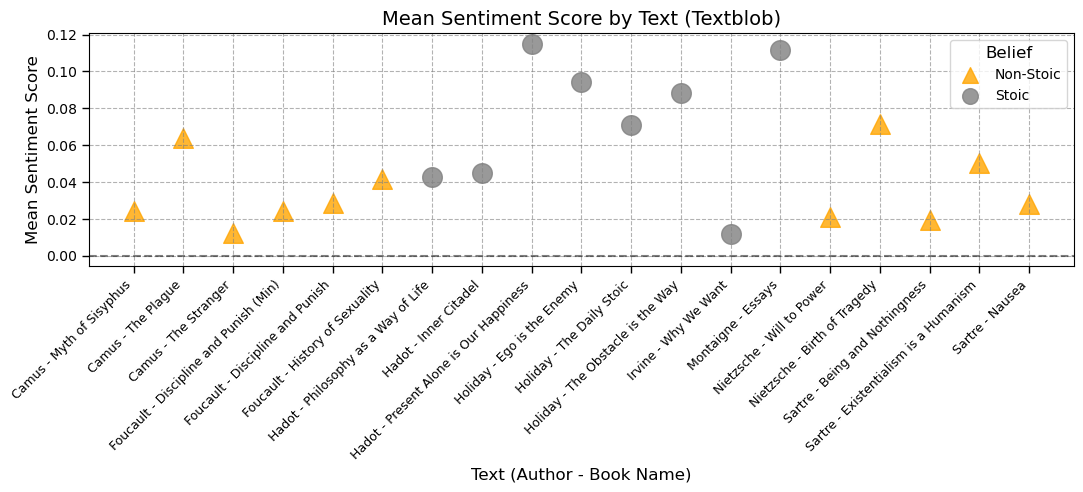

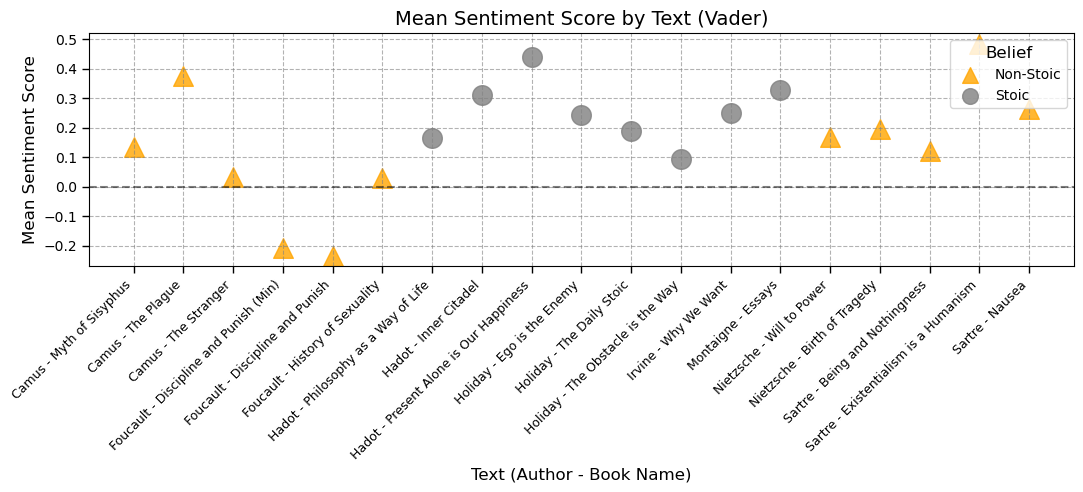

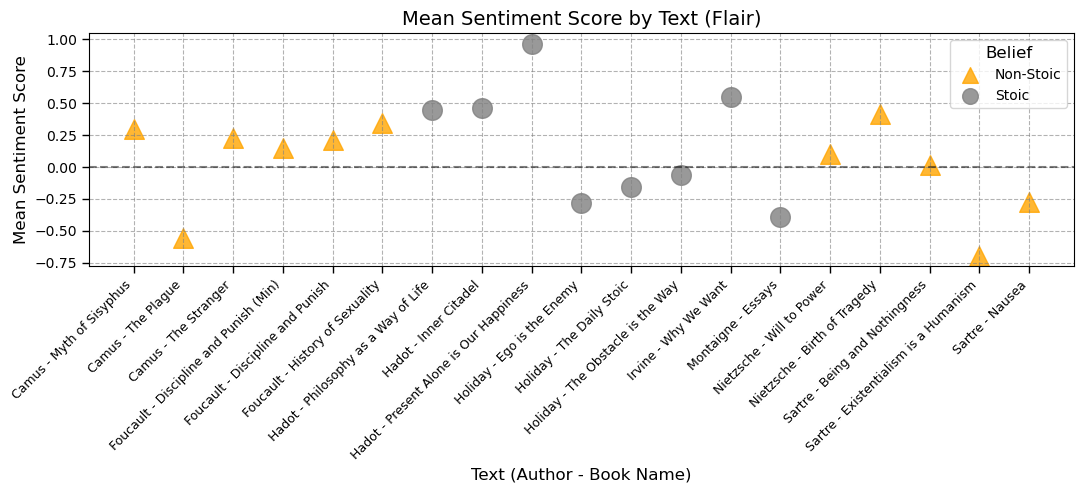

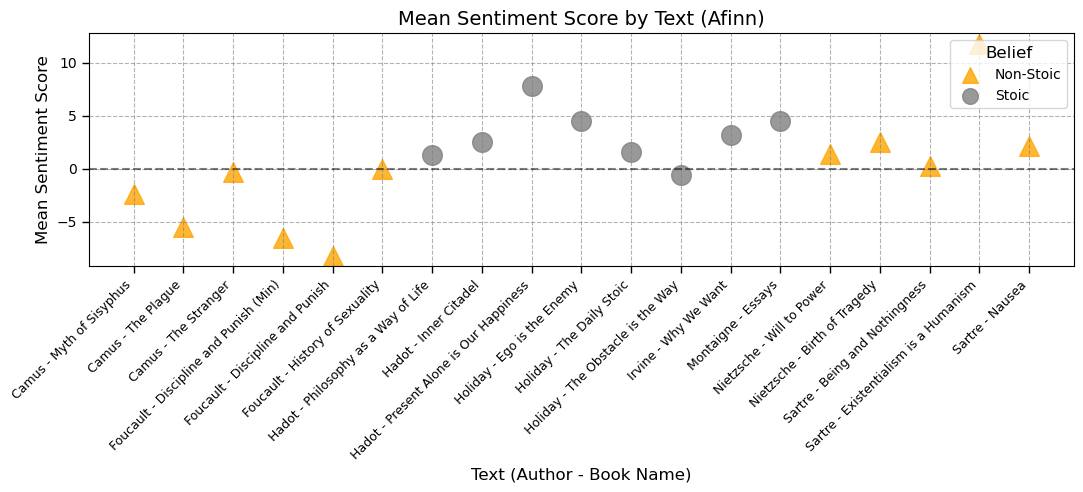

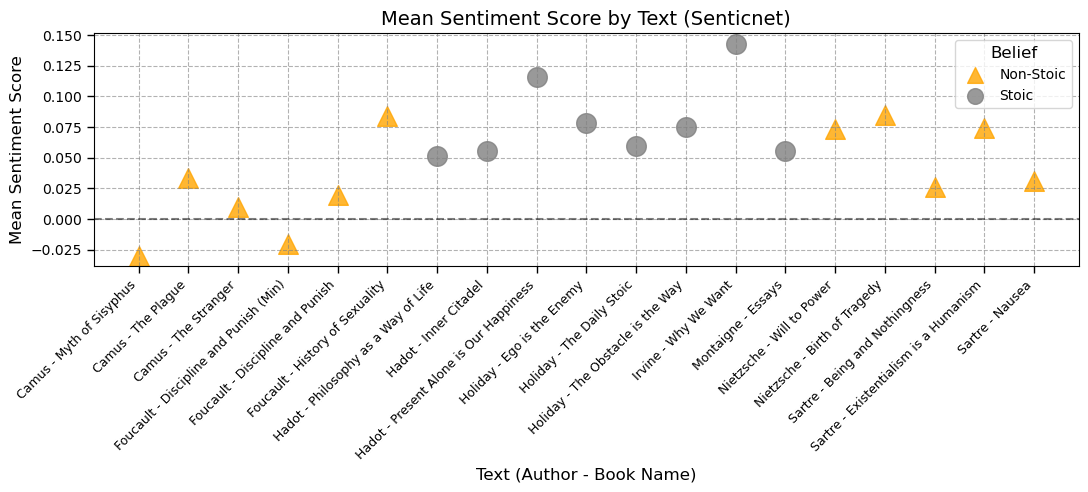

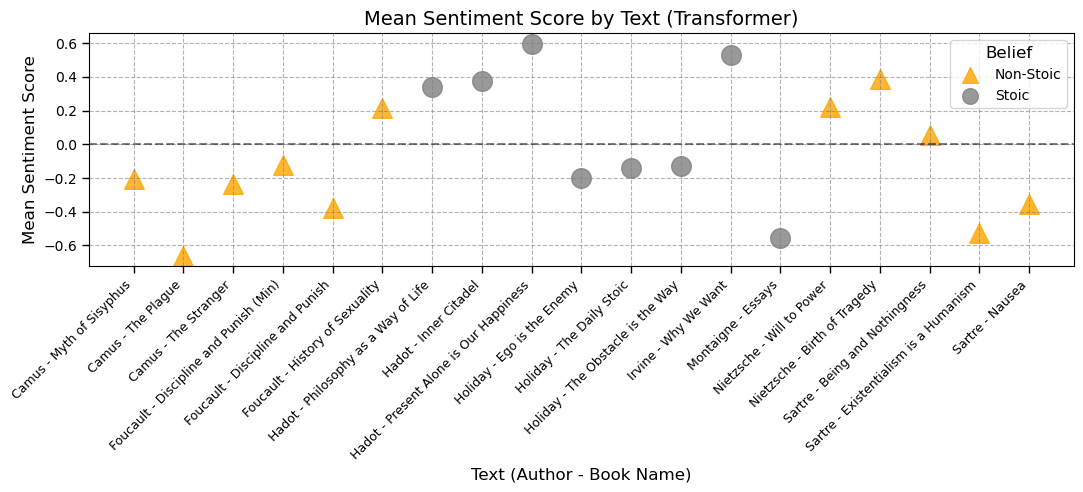

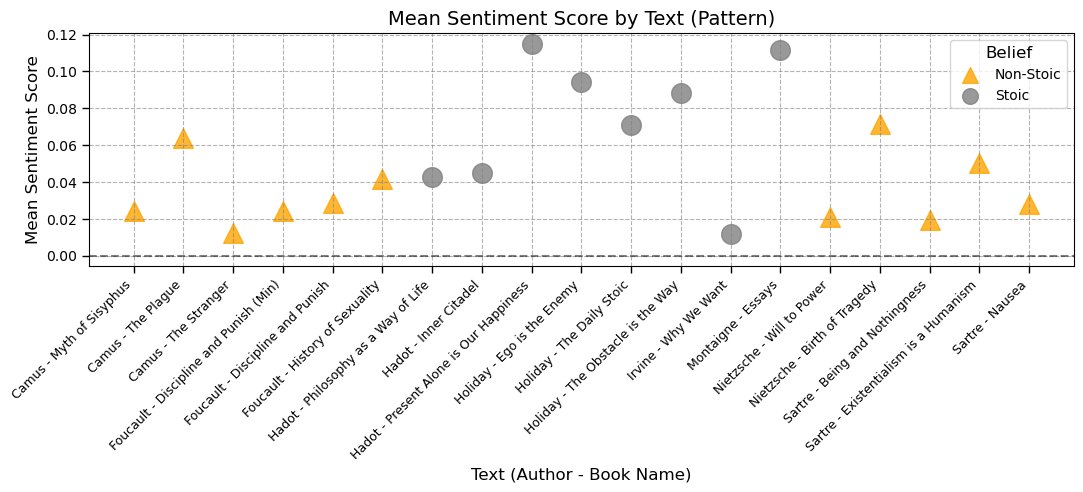

In [26]:
output_dir = 'plots_stoicism'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for metric in metrics:
    plt.figure(figsize=(11, 5))

    added_labels = {'Stoic': False, 'Non-Stoic': False}
    
    for index, row in stoicism_sentiment_df.iterrows():
        x = abbreviations_stoicism.get(row['filename'], row['filename'])
        y = row[metric]
        belief = row['belief']
        color = 'grey' if belief == 'Stoic' else 'orange'
        marker_shape = 'o' if belief == 'Stoic' else '^'
        
        if not added_labels[belief]:
            plt.scatter(x, y, color=color, s=200, alpha=0.8, label=belief, marker=marker_shape)
            added_labels[belief] = True
        else:
            plt.scatter(x, y, color=color, s=200, alpha=0.8, marker=marker_shape)
    
    plt.axhline(0, color='black', linestyle='--', linewidth=1.5, alpha = 0.5)
    
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.title(f'Mean Sentiment Score by Text ({metric.replace("mean_sentiment_score_", "").capitalize()})', fontsize=14)
    plt.xlabel('Text (Author - Book Name)', fontsize=12)
    plt.ylabel('Mean Sentiment Score', fontsize=12)
    
    plt.tight_layout()
    plt.grid(True, linestyle='--', alpha=0.6, color='gray')
    plt.tick_params(axis='both', which='both', length=5, width=1, color='black')  # Black ticks
    
    legend = plt.legend(title='Belief', fontsize=10, title_fontsize=12, loc='upper right', markerscale=0.8)
    
    plt.savefig(os.path.join(output_dir, f'{metric}_stoicism_plot.png'), bbox_inches='tight')
    
    plt.show()